In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from google.colab import files
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Upload Dataset
uploaded = files.upload()
df = pd.read_csv(list(uploaded.keys())[0])
df.head()


Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
#DATA PREPROCESSING

# Fix TotalCharges missing values
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

# Encode target
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# Label encode remaining categorical columns
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = le.fit_transform(df[col])

# Check data quality
print("Missing values:\n", df.isna().sum())
df.head()


Missing values:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5375,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,3962,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0
2,2564,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,1
3,5535,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,0
4,6511,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1


Before SMOTE:
 Churn
0    4139
1    1495
Name: count, dtype: int64

After SMOTE:
 Churn
0    4139
1    4139
Name: count, dtype: int64
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}

Tuned Decision Tree Performance:
Accuracy : 0.7480482611781405
Precision: 0.5188866799204771
Recall   : 0.6978609625668449
F1 Score : 0.5952109464082098


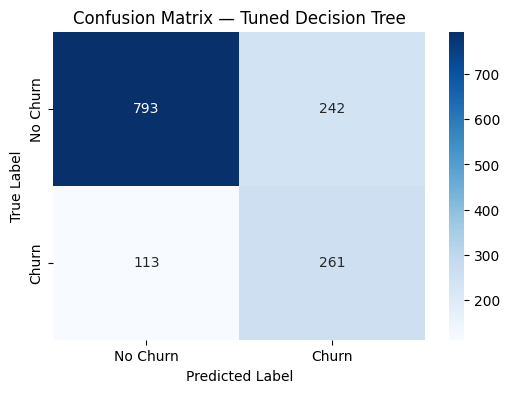

In [4]:
#    DECISION TREE MODEL


# Separate features and label
X = df.drop(columns=["Churn", "customerID"])
y = df["Churn"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Applying SMOTE to balance the training data
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print("Before SMOTE:\n", y_train.value_counts())
print("\nAfter SMOTE:\n", pd.Series(y_train_resampled).value_counts())

# GridSearch tuning
param_grid = {
    "max_depth": [3, 5, 10, None],
    "criterion": ["gini", "entropy"],
    "min_samples_split": [2, 5, 10]
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

dt_grid.fit(X_train_resampled, y_train_resampled)
best_dt = dt_grid.best_estimator_

print("Best Parameters:", dt_grid.best_params_)

# Predict on original test set
y_pred_best_dt = best_dt.predict(X_test)

# Performance
print("\n Decision Tree Performance:")
print("Accuracy :", accuracy_score(y_test, y_pred_best_dt))
print("Precision:", precision_score(y_test, y_pred_best_dt))
print("Recall   :", recall_score(y_test, y_pred_best_dt))
print("F1 Score :", f1_score(y_test, y_pred_best_dt))

# Confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_best_dt)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Churn", "Churn"],
            yticklabels=["No Churn", "Churn"])
plt.title("Confusion Matrix — Tuned Decision Tree")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,185 (4.63 KB)

 Trainable params: 1,185 (4.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6445 - loss: 0.5927 - val_accuracy: 0.7428 - val_loss: 0.6839
Epoch 2/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7626 - loss: 0.4895 - val_accuracy: 0.7204 - val_loss: 0.6789
Epoch 3/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7805 - loss: 0.4655 - val_accuracy: 0.7415 - val_loss: 0.6082
Epoch 4/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7757 - loss: 0.4631 - val_accuracy: 0.7428 - val_loss: 0.5996
Epoch 5/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7783 - loss: 0.4664 - val_accuracy: 0.7331 - val_loss: 0.6026
Epoch 6/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7856 - loss: 0.4426 - val_accuracy: 0.7476 - val_loss: 0.5652
Epoch 7/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7921 - loss: 0.4402 - val_accuracy: 0.6872 - val_loss: 0.6673
Epoch 8/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7814 - loss: 0.4585 - val_accuracy: 0.

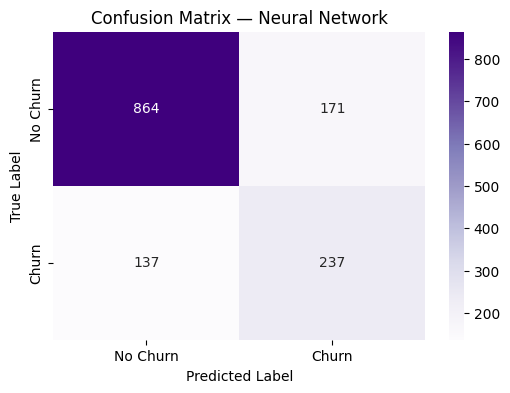

In [5]:

#  NEURAL NETWORK MODEL (NN)



# Scale features for NN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE for NN
X_train_resampled_nn, y_train_resampled_nn = sm.fit_resample(X_train_scaled, y_train)

# Build NN model
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.1),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

# Train NN
history = model.fit(
    X_train_resampled_nn, y_train_resampled_nn,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Predictions
y_pred_nn = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Performance
print("\nNeural Network Performance:")
print("Accuracy :", accuracy_score(y_test, y_pred_nn))
print("Precision:", precision_score(y_test, y_pred_nn))
print("Recall   :", recall_score(y_test, y_pred_nn))
print("F1 Score :", f1_score(y_test, y_pred_nn))

# Confusion Matrix
cm_nn = confusion_matrix(y_test, y_pred_nn)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_nn, annot=True, fmt="d", cmap="Purples",
            xticklabels=["No Churn", "Churn"],
            yticklabels=["No Churn", "Churn"])
plt.title("Confusion Matrix — Neural Network")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


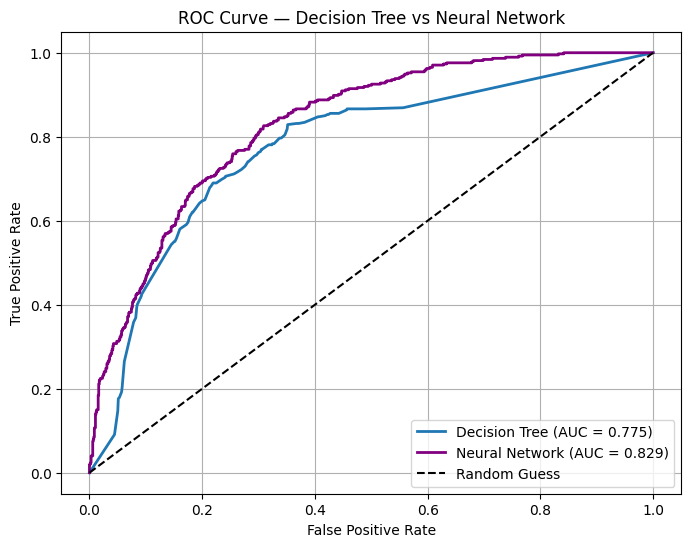

In [6]:

#  ROC CURVE — DTM vs NN


from sklearn.metrics import roc_curve, auc

# 1) Get predicted probabilities
dtm_probs = best_dt.predict_proba(X_test)[:, 1]     # Decision Tree probabilities
nn_probs = model.predict(X_test_scaled).ravel()      # Neural Network probabilities

# 2) Compute ROC curve values
fpr_dtm, tpr_dtm, _ = roc_curve(y_test, dtm_probs)
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_probs)

# 3) Compute AUC scores
auc_dtm = auc(fpr_dtm, tpr_dtm)
auc_nn  = auc(fpr_nn, tpr_nn)

# 4) Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_dtm, tpr_dtm, label=f"Decision Tree (AUC = {auc_dtm:.3f})", linewidth=2)
plt.plot(fpr_nn, tpr_nn, label=f"Neural Network (AUC = {auc_nn:.3f})", linewidth=2, color='purple')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Decision Tree vs Neural Network")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
